### Fill in name of notebook file
This might seem silly, but the version check below needs to know the filename of the current notebook, which is not trivial to find out programmatically.

You might want to have several parallel versions of the notebook, and it is fine to rename the notebook as long as it stays in the same directory. **However**, if you do rename it, you also need to update its own filename below:

In [6]:
nb_fname = "HA2-Part1.ipynb"

### Check Python version

In [8]:
from platform import python_version_tuple

assert (
    python_version_tuple()[:2] == ("3", "11")
), "You are not running Python 3.11. Make sure to run Python through the course Conda environment."

### Check that notebook server has access to all required resources, and that notebook has not moved

In [4]:
import os

nb_dirname = os.path.abspath("")
assignment_name = os.path.basename(nb_dirname)
assert assignment_name in [
    "IHA1",
    "IHA2",
    "HA1",
    "HA2",
], "[ERROR] The notebook appears to have been moved from its original directory"

### Verify correct nb_fname

In [9]:
from IPython.display import HTML, display

try:
    display(
        HTML(
            r'<script>if("{nb_fname}" != IPython.notebook.notebook_name) {{ alert("You have filled in nb_fname = \"{nb_fname}\", but this does not seem to match the notebook filename \"" + IPython.notebook.notebook_name + "\"."); }}</script>'.format(
                nb_fname=nb_fname
            )
        )
    )
except NameError:
    assert False, "Make sure to fill in the nb_fname variable above!"

### Verify that your notebook is up-to-date and not corrupted in any way

In [10]:
import sys

sys.path.append("..")
from ha_utils import check_notebook_uptodate_and_not_corrupted

check_notebook_uptodate_and_not_corrupted(nb_dirname, nb_fname)

Matching current notebook against the following URL:
http://raw.githubusercontent.com/dml-cth/deep-machine-learning/master/home-assignments/HA2/HA2-Part1.ipynb
[SUCCESS] No major notebook mismatch found when comparing to latest GitHub version. (There might be minor updates, but even that is the case, submitting your work based on this notebook version would be acceptable.)


# HA2 - Recurrent Neural Networks

This assignment is divided into two parts. In the first one, you will implement a vanilla RNN module from scratch using PyTorch to perform the task of predicting the nationality of a given name. In the second, you will implement many of the components in a Transformer block, and use it to classify movie reviews as positive or negative. 

For efficient use of GPU hours, you can do all development up until the training on a CPU. You can then run the training on a GPU for faster training times.

**IMPORTANT NOTES:**
Some cells contain compiled tests. For them to work propery, make sure to keep function and class names.
Similarly to IHA1, IHA2 and HA1 some questions in this notebook will not be graded in detail, but we still expect you to answer them. Those questions are marked with (0 points) and, as well as the other questions in this notebook, they may appear in the Inspera test.
You won’t need to train neural networks in Inspera test.

# Task 1 - Predicting Nationalities

In this task, you will create an RNN module using PyTorch, and train it to predict the nationality of a given input name. Your RNN will process each character of an input name at a time, and at the last character output a probability mass function over the possible countries.

The data for this task is present in the file `data/nam_dict.txt`. After parsing it we will have around 44k names from 41 different countries.

---
## 1.0 Imports

Import all dependencies

In [11]:
from utils.tests import ha2_part1_tests
%load_ext autoreload
%autoreload 2

from utils.load_names import get_data_from_file

import matplotlib.pyplot as plt
import numpy as np
import torch

---
## 1.1 Loading the data

We'll start by loading the data from the `nam_dict.txt` file, using the provided method `get_data_from_file`.

In [12]:
names_dict = get_data_from_file("data/nam_dict.txt")

The newly-created variable `names_dict` is a dictionary where each country is a key, and the value is the corresponding list of names from that country.

In [13]:
names_dict.keys()

dict_keys(['Great Britain', 'Ireland', 'U.S.A.', 'Italy', 'Portugal', 'Spain', 'France', 'the Netherlands', 'East Frisia', 'Germany', 'Swiss', 'Iceland', 'Denmark', 'Norway', 'Sweden', 'Finland', 'Estonia', 'Latvia', 'Lithuania', 'Hungary', 'Romania', 'Bulgaria', 'Bosnia and Herzegovina', 'Croatia', 'Kosovo', 'Serbia', 'Albania', 'Greece', 'Russia', 'Ukraine', 'Armenia', 'Azerbaijan', 'Kazakhstan/Uzbekistan,etc.', 'Turkey', 'Arabia/Persia', 'Israel', 'China', 'India/Sri Lanka', 'Japan', 'Korea', 'Vietnam'])

In [14]:
names_dict["Greece"][:10]

['Achilleas',
 'Achillefs',
 'Adamantia',
 'Adamantini',
 'Adamantios',
 'Aeneas',
 'Afroditi',
 'Agapi',
 'Agapios',
 'Agathi']

Let's look at the dataset in more detail. Plot the number of names in each country using a [bar plot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.bar.html).

*Hints*:

- You can put labels in the x-axis using the method [`xticks`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.xticks.html).
- The `xticks` method accepts a keyword argument named `rotation`.

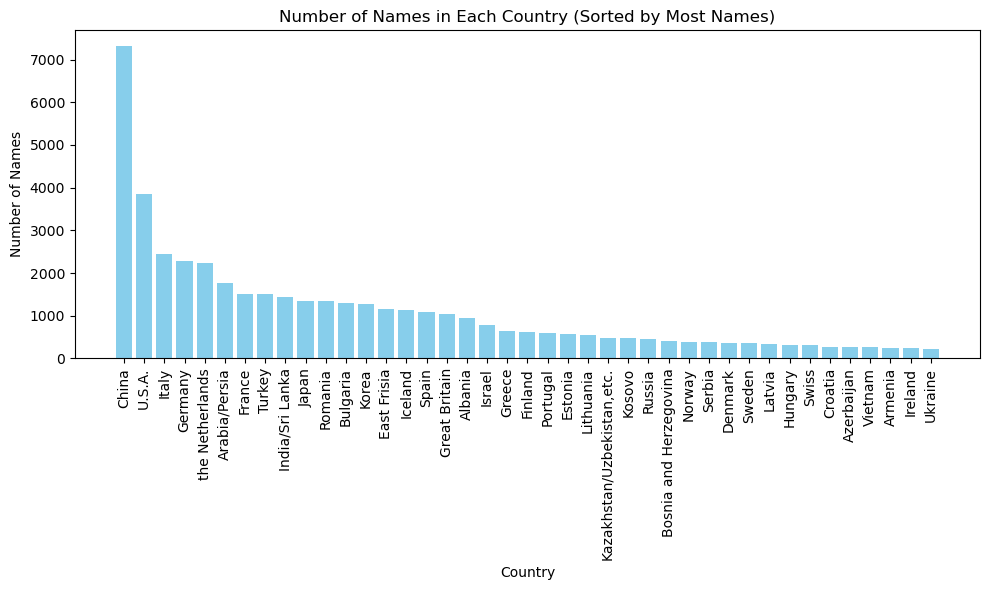

In [15]:
%matplotlib inline

country_names_count = {country: len(names) for country, names in names_dict.items()}

sorted_country_names_count = dict(sorted(country_names_count.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.bar(sorted_country_names_count.keys(), sorted_country_names_count.values(), color='skyblue')
plt.xticks(rotation=90) 
plt.xlabel('Country')
plt.ylabel('Number of Names')
plt.title('Number of Names in Each Country (Sorted by Most Names)')
plt.tight_layout()
plt.show()



**[0 point]** Is this dataset balanced? If not, which are the top-5 countries with most names?

**Your answer:** The dataset is not balanced, from the sorted plot above we se that the countries differ alot, the top five are: China, USA, Italy, Germany, and The Netherlands

---
## 1.2 Pre-processing

We will train an RNN which takes as input one character at each time-step. In order to do so, we will encode every character in the input names into a one-hot representation that is more suited to be fed to neural networks. 

The first thing we need to do is to decide the size of the alphabet used for the one-hot encoding. To do so, let's take a look at all the characters used in the dataset. A simple way to do so is putting all names in the same string and then using a `set` to get the unique values. We'll treat upper-case and lower-case characters as being the same.

In [16]:
temp = " "
for name_list in names_dict.values():
    for name in name_list:
        temp += name.lower()
charset = sorted(set(temp))
print(f"{len(charset)} characters:")
charset

57 characters:


[' ',
 "'",
 '-',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'ß',
 'à',
 'á',
 'â',
 'ã',
 'ä',
 'å',
 'æ',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'í',
 'î',
 'ï',
 'ð',
 'ñ',
 'ò',
 'ó',
 'ô',
 'õ',
 'ö',
 'ø',
 'ú',
 'ü',
 'ý',
 'þ']

**[1 point]** We will now create a function that takes as input a name and the set of characters, and outputs a `(name length) x (charset length)` tensor, with each row being a one-hot encoding of the corresponding character. Complete the function below.

In [17]:
def name2tensor(name, charset):
    name = name.lower()

    tensor = None

    tensor = torch.zeros(len(name), len(charset))
    for i, char in enumerate(name):
        tensor[i][charset.index(char)] = 1
    
    return tensor

Run the following cell without changing anything to test your implementation of the above method. 

In [18]:
ha2_part1_tests.test_name2_tensor(name2tensor)

Test passed


Let us look at an example tensor for a name.

In [19]:
print(name2tensor("Ali", charset))
print('charset: ', charset)

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
charset:  [' ', "'", '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è'

**[0 point]** Why does the above output tensor contain a 1 at position (0,3)?


**Your answer:**
Since A is te first character, the corresponding row is the row with index 0. Column 3 is explained by A having that index in the charset. If there would only be letters in the charset, A sould be at position 1, but since there are some special characters present this explains it being at position 3.

**[0 point]** What would if you try encoding the string `Lol@` using this function? Why?

**Your answer:** A ValueError would be rasied as @ does not exist in the charset

**[2 points]**

It's definitely possible to use the tensors created with `name2tensor` to train our RNN, but in that case we would only be able to conveniently perform forward-propagation using one sample at a time.

Instead, we want to batch samples together and parallelize the forward-propagation step. To do so, all samples must have the same dimensions (right now every sample has dimension `(name length) x (charset length)`, and the length of the names varies). Modify the function `name2padded_tensor` to achieve this by padding the start of the tensor with zeros, so that the output tensor always has length `target_len x (charset length)`.

*Hint*:

- To make it easier to catch bugs in the next parts of the assignment, make sure to raise an exception if the `target_len` is smaller than the length of the input word.

In [20]:
def name2padded_tensor(name, target_len, charset):
    tensor = name2tensor(name, charset)
    # YOUR CODE HERE
    name_len, charset_len = tensor.shape

    if target_len < name_len:
            raise ValueError(f"Target length ({target_len}) is smaller than the name length ({name_len}).")
    
    temo_tensor = torch.zeros(target_len, charset_len)

    # Copy the original tensor to the end of the temporary tensor
    temo_tensor[-name_len:] = tensor

    tensor = temo_tensor
        
    return tensor



In [23]:
ha2_part1_tests.test_name2_tensor(name2tensor)

Test passed


**[1 point]** What should be the target length for our case in this dataset? Compute it (i.e. don't hardcode it) in the cell below and save it in a variable named `target_len`, which will be used from here on

In [24]:
longest_name_length = 0

for country, names in names_dict.items():
    for name in names:
        longest_name_length = max(longest_name_length, len(name))

target_len = longest_name_length

print(f"The target length (longest name) is: {target_len}")

The target length (longest name) is: 22


In [25]:
ha2_part1_tests.test_target_len(target_len)

Test passed


Now we can go through the entire dataset, encode each of the names, and save all of it in a tensor. We'll do the same with the ground-truth labels for the countries of each name.

In [26]:
# Create the tensors that will hold the names and labels
# (note that the first dimension has 0 elements, this is a way to initialize an empty tensor for concatenating later)
xs = torch.zeros(0, target_len, len(charset))
ys = torch.zeros(0, dtype=torch.long)

for i, country in enumerate(names_dict.keys()):
    # Apply the name2padded_tensor function to each name in this country
    temp = map(lambda n: name2padded_tensor(n, target_len, charset), names_dict[country])

    # Add a new dimension to the resulting tensors
    temp = [name_tensor[None, :, :] for name_tensor in temp]

    # Concatenate all of them along this new dimension
    names_tensor = torch.cat(temp, dim=0)

    # Add these tensors to `xs`
    # Note that we have 44504 data pairs (x,y) where a single input x has the shape (target_len, 57),
    # where 57 is the length of the one-hot-encoded vectors.
    xs = torch.cat([xs, names_tensor], dim=0)

    # Create tensor filled with i`s and add that to the ground-truth tensor
    ys_for_this_country = torch.zeros(names_tensor.shape[0], dtype=torch.long) + i
    ys = torch.cat([ys, ys_for_this_country])

In [27]:
xs.shape

torch.Size([44504, 22, 57])

In [28]:
ys.shape

torch.Size([44504])

Now we can create a dataset with these tensors.

In [29]:
from torch.utils.data import TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
dataset = TensorDataset(xs.to(device), ys.to(device))

Using cpu


And split it in training, validation, and test sets.

In [30]:
from torch.utils.data import random_split

val_ratio = 0.15
test_ratio = 0.15

n_samples = len(dataset)
n_val_samples = int(n_samples * val_ratio)
n_test_samples = int(n_samples * test_ratio)
n_train_samples = n_samples - n_val_samples - n_test_samples

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [n_train_samples, n_val_samples, n_test_samples]
)

---
### 1.3 Defining the optimization

Now we will define the model to be trained, that is, a single layer RNN. As usual, we will create a class for the model and inherit from `nn.Module`. Define in the next cell a class for an RNN that follows the equations:

$$ h_t = \text{tanh}(W_h x_t + U_h h_{t-1} + b_h) $$
$$ y_t = \log \Big(\text{Softmax}(W_y h_t + b_y)\Big)~,$$

where $h_t$ is the current hidden-state, $h_{t-1}$ is the previous hidden state, $x_t$ is the input, $y_t$ is the output, and $W_h, U_h, b_h, W_y, b_y$ are the trainable parts of the RNN. As explained before, we will use this RNN to classify names, inputting one character at each step and using the last output as the prediction for a distribution over probable countries for the name.

*Hints:*

- As you're probably aware by now, PyTorch [has a layer](https://pytorch.org/docs/stable/nn.html#logsoftmax) that already applies the log and the softmax in one pass.
- If you get errors related to size mismatches when computing the forward-propagation in your model, try reading the documentation for the specific module where the problem is occurring (e.g. [`nn.Linear`](https://pytorch.org/docs/stable/nn.html#linear)), especially the part about the expected shape of inputs and outputs.

**[2 points]**

In [31]:
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        Inputs:
            input_size     - Dimensionality of the input of this RNN.
            hidden_size    - Dimensionality of the hidden state.
            output_size    - Dimensionality of the output of this RNN.
        """

        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.W_h = nn.Linear(input_size, hidden_size)

        self.U_h = nn.Linear(hidden_size, hidden_size)
        
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
        self.W_y = nn.Linear(hidden_size, output_size)
        
        self.b_y = nn.Parameter(torch.zeros(output_size))
        
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        """
        Runs the RNN module for one time-step.
        Inputs:
            x              - Batch of one-hot encoded characters.
                             Tensor of size (BATCH SIZE x CHARSET LENGTH).
            h              - Batch of hidden states at previous time-step.
                             Tensor of size (BATCH SIZE x `hidden_size`).

        Returns:
            y              - Batch of outputs.
                             Tensor of size (BATCH SIZE x NUMBER OF COUNTRIES).
            new_h          - Batch of hidden states at current time-step.
                             Tensor of size (BATCH SIZE x `hidden_size`).
        """

        # Forward pass according to the formulas
        new_h = torch.tanh(self.W_h(x) + self.U_h(h) + self.b_h)
        
        y = self.log_softmax(self.W_y(new_h) + self.b_y)

        return y, new_h

Run the following cell to test whether the shape of your outputs are correct. Note that this *only* checks the shapes and some basic ranges of outputs, not the content (one way you can check the actual computations of your network is to `print` the tensors as they pass through the layers, in order to check that the computations do what you expected).

In [32]:
ha2_part1_tests.test_model_output(RNN, device, names_dict, charset)

Test passed.


**[0 point]** Suppose we now create an RNN using the following call: `RNN(x, y, z)`. How many parameters would this model have in total?

In [33]:
# number of countries
print('Number of countries: ',len(names_dict))
# length of charset
print('Length of charset: ',len(charset))


Number of countries:  41
Length of charset:  57


**Your answer:**
Imput size would be the length of the charset which is 57 and z would be the length of the charset wich is 57. the y is determined by the hidden state we chose. The number of parameters is then defined by:

W_h = input_size * hidden_size  
U_h = hidden_size * hidden_size     
b_h = hidden_size                 
W_y = hidden_size * output_size  
b_y = output_size                 

Total parameters expression
P = W_h + U_h + b_h + W_y + b_y 

P = y^2 + 99*y + 41





We will use the Adam optimizer:

In [34]:
from torch.optim import Adam

And, since this is a classification problem we will use the negative log-likelihood loss ([`NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss)) to train the model. We should account for the fact that our dataset is imbalanced, and one way of dealing with this problem is to assign different weights to each class in our problem. More specifically, we want to give higher weights to examples belonging to the less frequent classes and lower weights to the more frequent ones.

In [35]:
# Compute weights for each class
n_names_for_each_country = [len(v) for v in names_dict.values()]
ns = torch.tensor(n_names_for_each_country, dtype=torch.float)
w = 1.0 / ns
w = w / w.sum()

 **[1 point]** Declare the appropriate weight criterion using the weights defined above.

In [36]:
# Define loss

criterion = torch.nn.NLLLoss(weight=w)

In [37]:
ha2_part1_tests.test_criterion(criterion, device)

Test passed.


**[0 point]** Why is it a problem that the dataset is imbalanced? What would be the consequence of not dealing with this problem?

**Your answer:**
 The model may achieve high accuracy overall by primarily predicting the high frequency classes, but it will perform poorly on the smaller classes. This can result in low sensitivity (true positive rate) for the smaller classes, leading to missed detections.

**[0 point]** Why does assigning different weights to each class solve this problem?

**Your answer:**
By giving higher weights to smaller classes, the model is penalized more for misclassifying these classes. This encourages the model to focus more on learning their features, aswell. Leading to improved predictive performance across all classes

**[0 point]** Is there any situation where *we would want* to introduce class imbalances in your dataset? How could we create such a class imbalance in a balanced dataset (without changing the dataset itself)?



**Your answer:**
When the real world distrobution is important, and the imbalance reflects the real-world situation, existing class imbalances could be beneficial because they reflect the true distribution of events, allowing models to make informed predictions.

---
### 1.4 Helper functions for training

Now that we defined the optimization problem, we can start creating the code to actually solve it. The first thing that we need is a function that, given a batch of samples, computes the output of the model for every sample and the average loss across all samples. 

Complete the function `batch_forward_prop` to produce this behavior.

*Hints*:

- Initialize the hidden state to a zero Tensor for the first forward-propagation.
- If you get errors related to size mismatches when computing the forward-propagation in your model, try reading the documentation for the specific module where the problem is occurring (e.g. [`nn.Linear`](https://pytorch.org/docs/stable/nn.html#linear)), especially the part about the expected shape of inputs and outputs.
- If you get errors related to size mismatches when computing the loss, try reading the [documentation for it](https://pytorch.org/docs/stable/nn.html#nllloss), especially the part about the expected shape of inputs and outputs.

**[2 points]**

In [38]:
def batch_forward_prop(rnn, xs, ys):
    """
    Inputs:
        rnn            - The RNN model, instance of the RNN class.
        xs             - Batch of input words.
                         Tensor of shape (BATCH SIZE x `target_len` x CHARSET LENGTH).
        ys             - Batch of ground-truth labels.
                         Tensor of  shape (BATCH_SIZE).

    Returns:
        output         - Output computed at the last character position in the batch.
                         Tensor of shape (BATCH_SIZE x NUMBER OF COUNTRIES).
        loss           - Value of the average loss across the predictions for this batch, later used for back-propagation.
                         Tensor with a single element inside.
    """

    batch_size= xs.size(0)
    hidden_size = rnn.hidden_size

    h = torch.zeros(batch_size, hidden_size)

    # Forward pass through the RNN
    for t in range(xs.size(1)): 
        x_t = xs[:, t, :] 
        y_t, h = rnn(x_t, h)  # Forward pass

 
    output = y_t 
    loss = criterion(output, ys) 

    return output, loss

Run the following cell to test whether the shape of your outputs are correct. Note that this *only* checks the shapes, not the content.

In [39]:
ha2_part1_tests.test_batch_forward_rnn(name2tensor_fn = name2tensor, 
                                       charset = charset,
                                       RNN_model = RNN,
                                       device = device,
                                       batch_forward_prop_fn = batch_forward_prop,
                                       names_dict = names_dict)

Test passed.


Using this function, it's straightforward to train on a single batch of data:

In [40]:
def train_batch(rnn, xs, ys, optimizer):
    # Compute the output for all samples in the batch and the average loss
    output, loss = batch_forward_prop(rnn, xs, ys)

    # Zero gradients before computing backward-propagation
    optimizer.zero_grad()

    # Backward-propagation
    loss.backward()

    # Clip the gradient norm (optional, helps to stabilize training)
    nn.utils.clip_grad_norm_(rnn.parameters(), 2)

    # Perform one step of optimization
    optimizer.step()

    return output, loss

We will also need a function for computing metrics of interest in the validation set. In this case, we will plot both the loss and the F1-score in the validation set. The F1-score of a classifier is the [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of its [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall), two metrics that are more useful than accuracy for imbalanced datasets. [This blog post](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9) can help you to familiarize yourself with these new metrics.

In [41]:
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics_on_validation_set(rnn, val_dataset):
    # Get all the input and labels in the validation set.
    x_val, y_val = val_dataset[:]

    # Perform forward-prop in the entire validation set, with autograd disabled
    with torch.no_grad():
        val_output, val_loss = batch_forward_prop(rnn, x_val, y_val)

    # Get numpy arrays for the true labels and the predictions
    y_true = y_val.cpu().numpy()
    y_pred = val_output.argmax(dim=1).cpu().numpy()

    # Compute precision, recall, and F-score
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro"
    )

    return val_loss, precision, recall, fscore

Lastly, we define a function for plotting the metrics in real-time.

In [42]:
def plot_metrics(fig, ax, ns, train_losses, train_fscores, val_losses, val_fscores):
    # Plot losses
    ax[0].clear()
    ax[0].plot(ns, train_losses)
    ax[0].plot(ns, val_losses)
    ax[0].set_title("Loss")
    ax[0].legend(["Train", "Validation"])
    ax[0].set_xlabel("Number of trained batches")
    ax[0].grid()

    # Plot F1-scores
    ax[1].clear()
    ax[1].plot(ns, train_fscores)
    ax[1].plot(ns, val_fscores)
    ax[1].plot(ns, [0.3] * len(ns), "k--")
    ax[1].set_title("Macro F1-score")
    ax[1].legend(["Train", "Validation", "F1-score threshold"])
    ax[1].set_xlabel("Number of trained batches")
    ax[1].grid()

    fig.canvas.draw()

With these helper functions, the `train` function becomes:

In [43]:
from torch.utils.data import DataLoader
%matplotlib inline

def train(rnn, n_epochs, learning_rate, batch_size, train_dataset, val_dataset):
    # Setup the figure for plotting progress during training
    
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
    plt.ion()
    plot_interval = 100

    # Create arrays to average training metrics across batches
    preds = []
    labels = []
    losses = []

    # Create dictionaries to hold the computed metrics in
    train_data = {"losses": [], "fscores": []}
    val_data = {"losses": [], "fscores": []}

    optimizer = Adam(rnn.parameters(), lr=learning_rate)
    train_data_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )
    batch_idxs = []

    # Training loop
    i_batch = 0
    for n in range(n_epochs):
        for i, (x_batch, y_batch) in enumerate(train_data_loader):
            i_batch += 1

            # Compute loss and outputs
            output, loss = train_batch(rnn, x_batch, y_batch, optimizer)

            # Aggregate for later averaging
            preds += output.argmax(dim=1).cpu().tolist()
            labels += y_batch.cpu().tolist()
            losses.append(loss)

            # Compute metrics and plot after every `plot_interval` batches
            if i % plot_interval == 0:
                val_loss, _, _, val_fscore = compute_metrics_on_validation_set(
                    rnn, val_dataset
                )
                train_fscore = precision_recall_fscore_support(
                    labels, preds, average="macro"
                )[2]

                val_data["losses"].append(val_loss.cpu())
                val_data["fscores"].append(val_fscore)
                train_data["losses"].append((sum(losses) / len(losses)).item())
                train_data["fscores"].append(train_fscore)
                batch_idxs.append(i_batch)

                preds = []
                labels = []
                losses = []

                plot_metrics(
                    fig,
                    ax,
                    batch_idxs,
                    train_data["losses"],
                    train_data["fscores"],
                    val_data["losses"],
                    val_data["fscores"],
                )
                
        print(f"Last step validation loss: {val_loss:.3f}, F1-score: {val_fscore:.3f}")

Make sure that you completely understand the `train` function before proceeding (e.g. that we aggregate predictions from different batches and compute metrics only at a certain interval, etc).

---
### 1.5 Training!

**[1 point]**
Now we're ready to train the network! Create an RNN and use the `train` function to train it.

*Hints*:

- Tuning the hyper-parameters (number of hidden units, learning rate, batch size, etc) will take some trial-and-error. Try simple things first, and then once you manage to train them, start scaling up. Also, have in mind the bias-variance tradeoff mentioned in the lectures.
- When tuning the learning rate, focus first on being able to decrease the training loss. Keep decreasing the learning rate until that starts happening.
- You should use a GPU for fast training times. Using a CPU, training a network can take ~5-10 minutes with suitable hyper-parameters. With a GPU training takes ~1 minute with the same hyper-parameters.

**Note:** If the interactive plots don't work, try to downgrade the notebook as following:

```!pip install notebook==6.5 traitlets==5.9```

c:\Users\Extra 1\.conda\envs\dml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Extra 1\.conda\envs\dml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Last step validation loss: 3.721, F1-score: 0.006


c:\Users\Extra 1\.conda\envs\dml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Extra 1\.conda\envs\dml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Last step validation loss: 3.386, F1-score: 0.125
Last step validation loss: 3.057, F1-score: 0.161
Last step validation loss: 2.837, F1-score: 0.190
Last step validation loss: 2.725, F1-score: 0.223
Last step validation loss: 2.650, F1-score: 0.243
Last step validation loss: 2.590, F1-score: 0.247
Last step validation loss: 2.527, F1-score: 0.256
Last step validation loss: 2.509, F1-score: 0.256
Last step validation loss: 2.448, F1-score: 0.275
Last step validation loss: 2.426, F1-score: 0.268
Last step validation loss: 2.383, F1-score: 0.283
Last step validation loss: 2.381, F1-score: 0.292
Last step validation loss: 2.352, F1-score: 0.290
Last step validation loss: 2.332, F1-score: 0.297
Last step validation loss: 2.312, F1-score: 0.293
Last step validation loss: 2.307, F1-score: 0.304
Last step validation loss: 2.296, F1-score: 0.294
Last step validation loss: 2.281, F1-score: 0.300
Last step validation loss: 2.256, F1-score: 0.313
Last step validation loss: 2.249, F1-score: 0.316


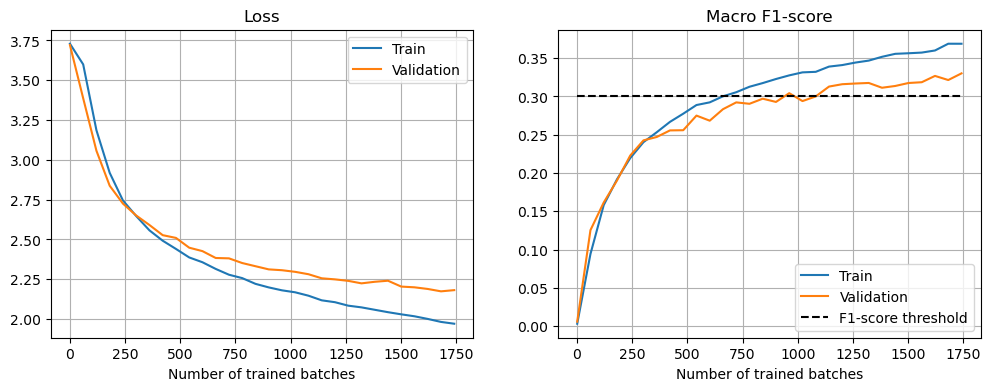

In [44]:
# YOUR CODE HERE
rnn = RNN(len(charset),128, len(names_dict))
rnn.to(device)
train(rnn, 30, 0.001, 512, train_dataset, val_dataset)

In [45]:
_, _, _, fscore = compute_metrics_on_validation_set(rnn, val_dataset)
ha2_part1_tests.test_min_f1_score(fscore)

Test passed


---
### 1.6 Evaluation

Now that our model is trained, we can evaluate its predictions on the test set. 

In [46]:
# Get all samples from the test set
x_test, y_test = test_dataset[:]

# Compute predictions
with torch.no_grad():
    test_out, _ = batch_forward_prop(rnn, x_test, y_test)

# Transform them into hard predictions
preds = test_out.argmax(dim=1)

# Get `preds` as a numpy array
preds = preds.cpu().numpy()

Using these predictions, we can compute the confusion matrix on the test set as follows.

In [47]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
y_true = y_test.cpu().numpy()
cm = confusion_matrix(y_true, preds)
cm = cm.astype("float64")

# Normalize each row
for i in range(cm.shape[0]):
    cm[i, :] = cm[i, :] / sum(cm[i, :])

cm

array([[0.12738854, 0.08280255, 0.08917197, ..., 0.        , 0.02547771,
        0.02547771],
       [0.        , 0.21212121, 0.        , ..., 0.        , 0.        ,
        0.03030303],
       [0.04718693, 0.02540835, 0.13430127, ..., 0.00362976, 0.00544465,
        0.02722323],
       ...,
       [0.        , 0.        , 0.00480769, ..., 0.8125    , 0.00961538,
        0.02403846],
       [0.        , 0.00518135, 0.00518135, ..., 0.        , 0.64766839,
        0.06217617],
       [0.        , 0.        , 0.        , ..., 0.        , 0.02777778,
        0.88888889]])

In order to make this easier to visualize, let's plot it as a heat map:

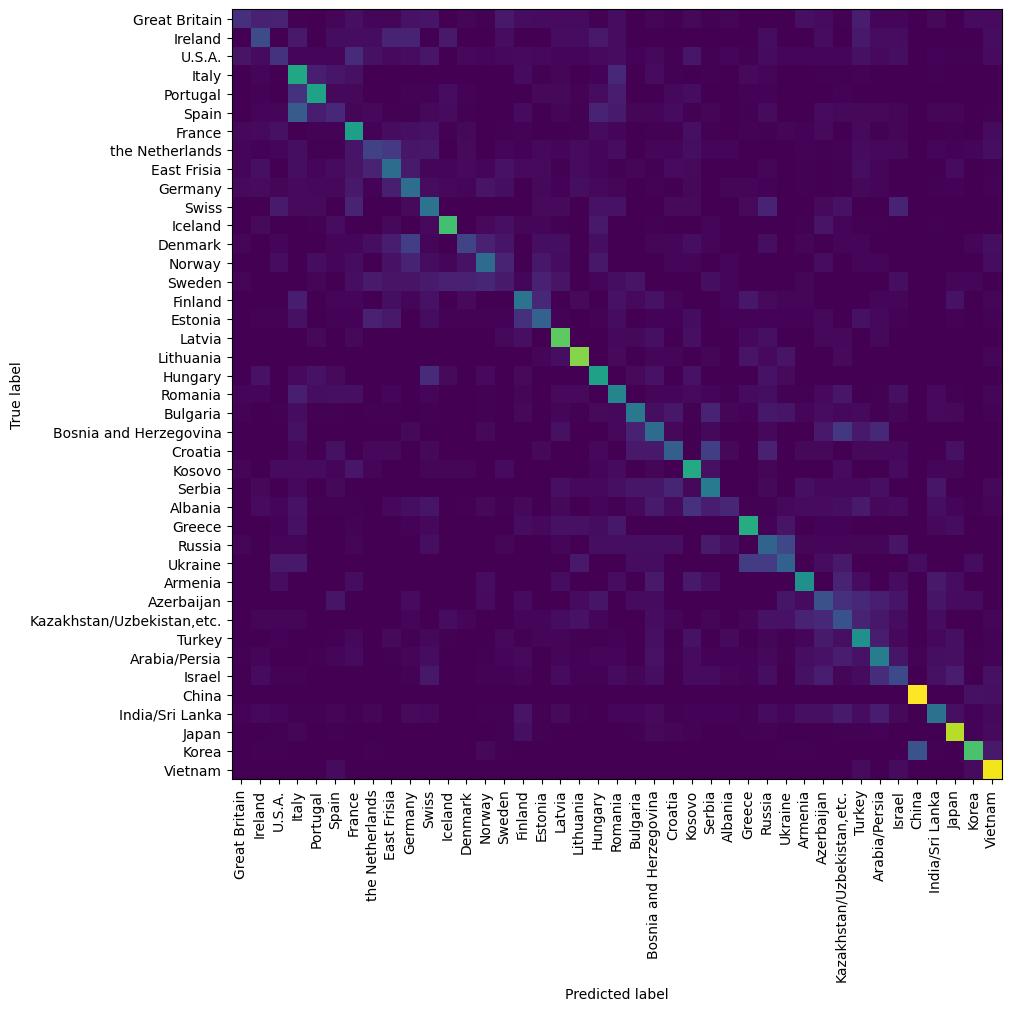

In [48]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(cm)
plt.xticks(range(len(names_dict)), names_dict.keys(), rotation="vertical")
plt.yticks(range(len(names_dict)), names_dict.keys())
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

**[0 point]** Why did we normalize the rows of the confusion matrix?

**Your answer:**
We normalize the rows of the confusion matrix to account for class imbalances. This ensures that the evaluation and coloring in the matrix is not biased toward the larger classes and allows us to compare the model's performance across all classes.

**[0 point]** What can you conclude from this confusion matrix? Which classes are easy/hard to classify? Which classes are being confused? 

**Your answer:**
The deeper the yellow on the diagnol the better accuracy the prediction has. If many rows in a colum of a specific country has a deeper yellow, we have many false positives. We see that Iceland, Latvia, China, Japan, Korea, and Vietnam performe very well. We can also se for instance that Italy have many false positives of names that are actually spanish.

To end this task, we can now define a function to perform predictions on any input name we provide (as long as the name contains only characters in our character set).

In [1]:
def evaluate(name_tensor):
    with torch.no_grad():
        hidden = torch.zeros(1, rnn.hidden_size).to(device)
        for i in range(name_tensor.shape[1]):
            output, hidden = rnn(name_tensor[:, i, :], hidden)
    return output.exp()


def predict(input_line, charset, n_predictions=5):
    tensor = name2tensor(input_line, charset).to(device)[None, :]
    output = evaluate(tensor)

    # Get top N categories
    topv, topi = output.topk(n_predictions, 1, True)
    topv, topi = topv[0], topi[0]

    cats = [list(names_dict.keys())[i] for i in topi.cpu().numpy()]
    vs = topv.cpu().numpy()

    plt.figure(figsize=(10, 3))
    plt.bar(range(len(vs)), vs)
    plt.xticks(range(len(vs)), cats)

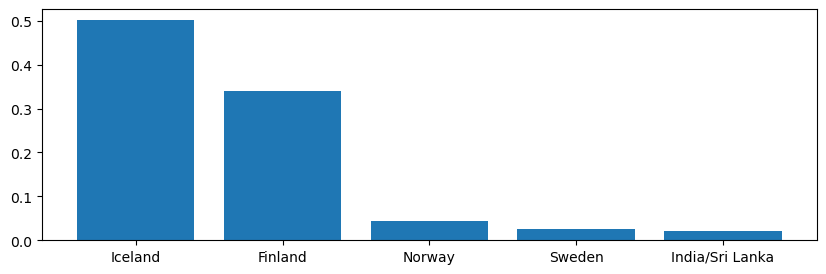

In [50]:
predict("Åsakvi", charset)

Experiment on new names using the next cell:

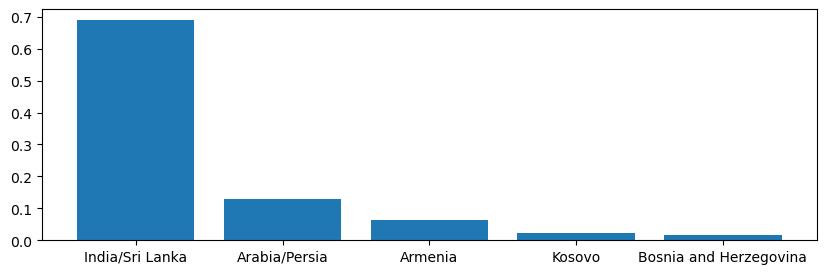

In [51]:
predict("Harakabim", charset)

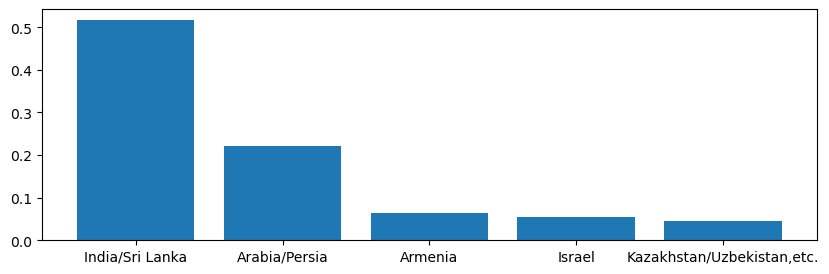

In [52]:
predict("Alakazam", charset)

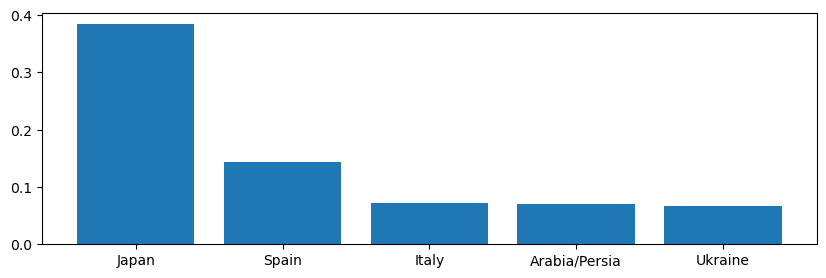

In [53]:
predict("Jin Quaio", charset)

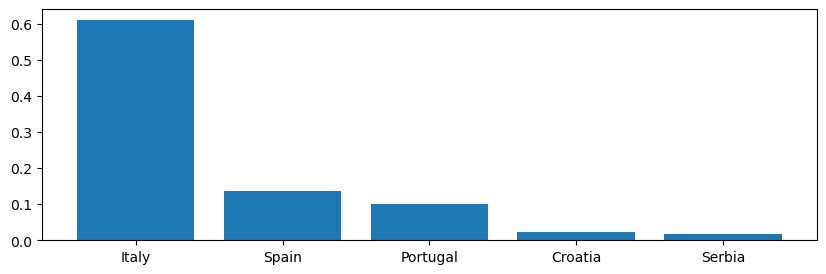

In [54]:
predict("Leonardino", charset)

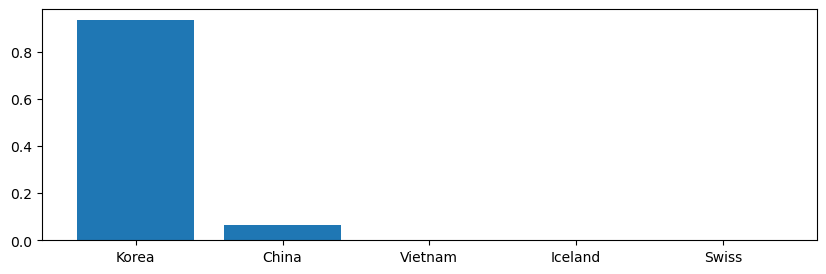

In [55]:
predict("Kim Sung", charset)

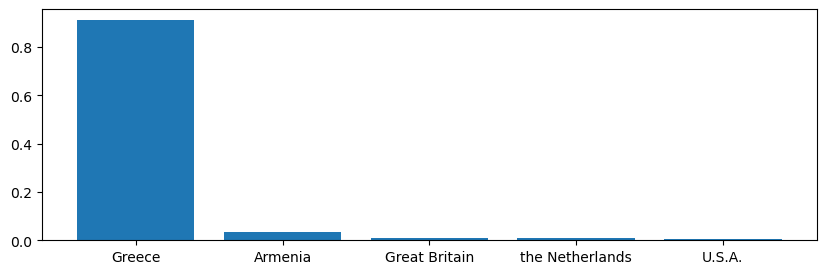

In [56]:
predict("Thanos", charset)

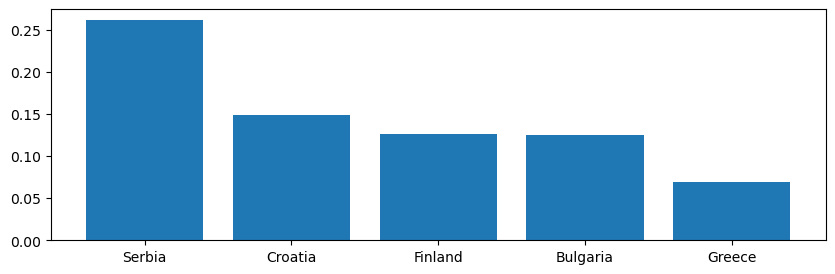

In [57]:
predict("Viiviika", charset)